In [1]:
#Generate plot 1 showing the efect of moments on the temp distribution.

In [2]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
import numbers
#np.set_printoptions(threshold=np.inf)
from scipy.special import erfinv, erf
import xskillscore as xs

In [3]:
def gauss_quantile(mean,std,quantile):
    #quantile must be a real number netween 0 and 1
    qvalue = mean + std * np.sqrt(2) * erfinv(2*quantile-1)
    return qvalue
    

In [4]:
#Chicago
LAT1        = 41.8781
LON1        = (360-87.6298)%360
#Boston
# LAT          = 42.3601
# LON          = (360-71.0589)%360
# #Bengaluru:
LAT2        = 12.9716
LON2        = 77.5946
#Berkeley
# LAT       = 37.8715
# LON       = (360-122.2730)%360
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
loc1       = 'Chicago/'
locn1      = 'Chicago'
loc2       = 'Bengaluru/'
locn2      = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
print(LAT1,LON1)
print(LAT2,LON2)

41.8781 272.3702
12.9716 77.5946


In [5]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = min(len(x), len(y))

    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)


In [6]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44215 instead
  warnings.warn(


In [7]:
cluster

In [8]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
doy      =  211# day_of_year #211 = Jul 30
date     = 'Jul30'

In [9]:
%%time
ds_ssp  = xr.open_mfdataset(cesm2_path+'ssp370_cesm2tmax.zarr',engine='zarr')
ds_hist = xr.open_mfdataset(cesm2_path+'bhist_cesm2tmax.zarr',engine='zarr')

CPU times: user 746 ms, sys: 139 ms, total: 885 ms
Wall time: 928 ms


In [10]:
%%time
#Close to (LAT, LON) ;t-temp, nw - no-warming, w-warming

tw_loc1  = ds_ssp.TREFHTMX.sel(lat=LAT1,lon=LON1,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))
tw_loc2  = ds_ssp.TREFHTMX.sel(lat=LAT2,lon=LON2,method='nearest',\
         time=ds_ssp.time.dt.dayofyear==doy).sel(time=slice(ic_year0,ic_year1))

tnw_loc1 = ds_hist.TREFHTMX.sel(lat=LAT1,lon=LON1,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
tnw_loc2 = ds_hist.TREFHTMX.sel(lat=LAT2,lon=LON2,method='nearest',\
         time=ds_hist.time.dt.dayofyear==doy).sel(time=slice(pi_year0,pi_year1))
tnw_loc2

CPU times: user 531 ms, sys: 12.1 ms, total: 543 ms
Wall time: 534 ms


<xarray.DataArray 'TREFHTMX' (time: 30, member: 100)>
dask.array<getitem, shape=(30, 100), dtype=float32, chunksize=(10, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 12.72
    lon      float64 77.5
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * time     (time) object 1850-07-30 00:00:00 ... 1879-07-30 00:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [11]:
%%time
#d = day/daily
tdnw_loc1 = tnw_loc1.stack(mtime=('member','time'),create_index=False)
tdw_loc1  = tw_loc1.stack(mtime=('member','time'),create_index=False)
#
tdnw_loc2 = tnw_loc2.stack(mtime=('member','time'),create_index=False)
tdw_loc2  = tw_loc2.stack(mtime=('member','time'),create_index=False)
#twj30.mean().values - tnwj30.mean().values 
#tdw.std().values 
tdw_loc1

CPU times: user 11.4 ms, sys: 1.06 ms, total: 12.5 ms
Wall time: 11.9 ms


<xarray.DataArray 'TREFHTMX' (mtime: 3000)>
dask.array<reshape, shape=(3000,), dtype=float32, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 41.94
    lon      float64 272.5
    member   (mtime) int64 0 0 0 0 0 0 0 0 0 0 ... 99 99 99 99 99 99 99 99 99 99
    time     (mtime) object 2071-07-30 00:00:00 ... 2100-07-30 00:00:00
Dimensions without coordinates: mtime
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

In [12]:
# Save daily,local tmax, mc = mean corrected, ms = mean and std-corrected
tdmc_loc1   = (tdnw_loc1 - tdnw_loc1.mean())+tdw_loc1.mean()
tdmsc_loc1  = (tdnw_loc1 - tdnw_loc1.mean())*(tdw_loc1.std()/tdnw_loc1.std()) + tdw_loc1.mean()
#
tdmc_loc2   = (tdnw_loc2 - tdnw_loc2.mean())+tdw_loc2.mean()
tdmsc_loc2  = (tdnw_loc2 - tdnw_loc2.mean())*(tdw_loc2.std()/tdnw_loc2.std()) + tdw_loc2.mean()
#Check if the transformation is correct
#tdmc.mean().values - tdw.mean().values

In [13]:
# tdw_mean = tdw.mean()
# tdw_std  = tdw.std()

In [14]:
# #########################
# tdgauss = xr.apply_ufunc(
#     np.random.normal,
#     tdw_mean,
#     tdw_std,
#     input_core_dims=[[], []],
#     output_core_dims=[['mtime']],
#     vectorize=True,
#     output_dtypes=[float],
#     kwargs={'size': 3000},
#      output_sizes={'mtime': 3000},
#     dask='parallelized'
# )
# tdgauss

In [15]:
# Set paths for local tmax - warming, no warming and corrected.
dnw_path1      = cvals+loc1+'tnw'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
dw_path1       = cvals+loc1+'tw'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_path1     = cvals+loc1+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_path1      = cvals+loc1+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
dnw_path2      = cvals+loc2+'tnw'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
dw_path2       = cvals+loc2+'tw'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_path2     = cvals+loc2+'tmsc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_path2      = cvals+loc2+'tmc'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
#dwgauss_path  = cvals+loc+'teoc_gauss'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
print(dnw_path1) 
print(dw_path2)
print(dmc_path2)

/global/scratch/users/harsha/LENS/cesm2/cvals/Chicago/tnwJul30_1850_1879_loc.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Bengaluru/twJul30_2071_2100_loc.zarr
/global/scratch/users/harsha/LENS/cesm2/cvals/Bengaluru/tmcJul30_2071_2100_loc.zarr


In [16]:
%%time
#### Save. #####ss
tdnw_loc1    = tdnw_loc1.chunk(dict(mtime=-1))
tdw_loc1     = tdw_loc1.chunk(dict(mtime=-1))
tdmc_loc1    = tdmc_loc1.chunk(dict(mtime=-1))
tdmsc_loc1   = tdmsc_loc1.chunk(dict(mtime=-1))
#
tdnw_loc2    = tdnw_loc2.chunk(dict(mtime=-1))
tdw_loc2     = tdw_loc2.chunk(dict(mtime=-1))
tdmc_loc2    = tdmc_loc2.chunk(dict(mtime=-1))
tdmsc_loc2   = tdmsc_loc2.chunk(dict(mtime=-1))
#tdgauss_loc1 = tdgauss_loc1.chunk(dict(mtime=-1))
# tdnw_loc1.to_dataset().to_zarr(dnw_path1,mode='w')
# tdw_loc1.to_dataset().to_zarr(dw_path1,mode='w')
# tdmc_loc1.to_dataset().to_zarr(dmc_path1,mode='w')
# tdmsc_loc1.to_dataset().to_zarr(dmsc_path1,mode='w')
#
# tdnw_loc2.to_dataset().to_zarr(dnw_path2,mode='w')
# tdw_loc2.to_dataset().to_zarr(dw_path2,mode='w')
# tdmc_loc2.to_dataset().to_zarr(dmc_path2,mode='w')
# tdmsc_loc2.to_dataset().to_zarr(dmsc_path2,mode='w')
# tdgauss_loc1.to_dataset().to_zarr(dwgauss_path1,mode='w')

CPU times: user 26.3 ms, sys: 1.17 ms, total: 27.5 ms
Wall time: 25.9 ms


In [17]:
#tdmsc.mean().values - tdw.mean().values

In [18]:
%%time
tdnw_loc1     = xr.open_zarr(dnw_path1)
tdw_loc1      = xr.open_zarr(dw_path1)
tdmc_loc1     = xr.open_zarr(dmc_path1)
tdmsc_loc1    = xr.open_zarr(dmsc_path1)
#
tdnw_loc2     = xr.open_zarr(dnw_path2)
tdw_loc2      = xr.open_zarr(dw_path2)
tdmc_loc2     = xr.open_zarr(dmc_path2)
tdmsc_loc2    = xr.open_zarr(dmsc_path2)
#tdgauss  = xr.open_zarr(dwgauss_path)
tdw_loc1     = tdw_loc1.TREFHTMX
tdnw_loc1    = tdnw_loc1.TREFHTMX
tdmsc_loc1   = tdmsc_loc1.TREFHTMX
tdmc_loc1    = tdmc_loc1.TREFHTMX
#
tdw_loc2     = tdw_loc2.TREFHTMX
tdnw_loc2    = tdnw_loc2.TREFHTMX
tdmsc_loc2   = tdmsc_loc2.TREFHTMX
tdmc_loc2    = tdmc_loc2.TREFHTMX
#tdgauss = tdgauss.TREFHTMX

CPU times: user 231 ms, sys: 47.6 ms, total: 279 ms
Wall time: 1.18 s


In [19]:
# ###### EOC Gaussian ##########
# tdgauss = np.random.normal(tdw.mean(),tdw.std(),size=3000)
# qdgauss = tdgauss.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

In [20]:
quants      = np.arange(0.01,1.00,0.01)
#qdgauss = tdgauss.quantile(quants,dim='mtime')
qdwgauss_loc1    = gauss_quantile(tdw_loc1.mean().values,tdw_loc1.std().values,quants)
qdwgauss_loc1    = xr.DataArray(qdwgauss_loc1, coords={'quantile': quants}, dims=["quantile"])
#
qdnwgauss_loc1   = gauss_quantile(tdnw_loc1.mean().values,tdnw_loc1.std().values,quants)
qdnwgauss_loc1   = xr.DataArray(qdnwgauss_loc1, coords={'quantile': quants}, dims=["quantile"])
#
qdwgauss_loc2    = gauss_quantile(tdw_loc2.mean().values,tdw_loc2.std().values,quants)
qdwgauss_loc2    = xr.DataArray(qdwgauss_loc2, coords={'quantile': quants}, dims=["quantile"])
#
qdnwgauss_loc2   = gauss_quantile(tdnw_loc2.mean().values,tdnw_loc2.std().values,quants)
qdnwgauss_loc2   = xr.DataArray(qdnwgauss_loc2, coords={'quantile': quants}, dims=["quantile"])

In [21]:
%%time
#Compute quantile function - Jan 1 tmax
qdnw_loc1   = tdnw_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw_loc1    = tdw_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc_loc1   = tdmc_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc_loc1  = tdmsc_loc1.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
#
qdnw_loc2   = tdnw_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdw_loc2    = tdw_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmc_loc2   = tdmc_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qdmsc_loc2  = tdmsc_loc2.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 173 ms, sys: 7.4 ms, total: 181 ms
Wall time: 176 ms


In [22]:
# qdwa  = qdw-qdnw
# qdca  = qdc-qdnw #w= warming, a = anomaly
# qdmca = qdc-qdnw
# qdw     = qdw.rename({'quantile':'permilles'})
# qdmc    = qdmc.rename({'quantile':'permilles'})
# qdmsc   = qdmsc.rename({'quantile':'permilles'})
# qdnw    = qdnw.rename({'quantile':'permilles'})
# qdgauss = qdgauss.rename({'quantile':'permilles'})

In [23]:
# qdw_path    = cvals+loc+'qw'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdnw_path   = cvals+loc+'qnw'+date+'_'+pi_year0+'_'+pi_year1+'.zarr'
# qdmc_path   = cvals+loc+'qmc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdmsc_path  = cvals+loc+'qmsc'+date+'_'+ic_year0+'_'+ic_year1+'.zarr'

In [24]:
# %%time
# plt.plot(quants,qdnw,'b--',label='pi')
# #plt.plot(quants,qdmc,label='pre-ind+ mean of '+ic_year0+'-'+ic_year1)
# plt.plot(quants,qdmc,'tomato',label='pre-ind+shift')
# plt.plot(quants,qdmsc,'g',label='pre-ind + shift+ stretch')
# plt.plot(quants,qdw,'b',label= ic_year0+'-'+ic_year1)
# plt.legend(loc='upper left')
# plt.title('CESM2:Lat='+str(LAT)+',Lon='+str(LON)+locn)
# plt.ylabel(date+'-Tmax (K)')
# plt.xlabel('Quantiles')
# plt.show()

In [25]:
# %%time
# ######## Boostrap Confidence Intervals for the quantiles #####
# #a = anomaly, b=bootstrap samples
# nboot   = 1000
# tdwb    = xs.resample_iterations(tdw,nboot,'mtime')
# # qdnwb   = tdnwb.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qdwb    = tdwb.chunk(dict(mtime=-1,iteration=-1)).quantile(quants,dim='mtime')
# qdwb

In [26]:
# %%time
# #qdwb_path  = cvals+loc+'qdw_10kboot' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# qdwb_path  = cvals+loc+'qdw' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
#  #qdwb.to_dataset().to_zarr(qdwb_path)
# #qdwb       = xr.open_zarr(qdwb_path)

In [27]:
# %%time
# qdwb     = qdwb.rename({'quantile':'permilles'})
# CIs      = [0.025,0.5,0.975]
# qdw_ci   = qdwb.chunk(dict(iteration=-1)).quantile(CIs,dim='iteration')

In [28]:
# %%time
# #Check for bootstrap bias
# plt.hist(qdwb.sel(permilles=0.025),density='True',bins=30,label='q=0.025;'+ic_year0+'_'+ic_year1)
# plt.xlabel(date+' Tmax(K), CESM2')
# plt.ylabel('Prob density')
# plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
# plt.legend(loc='upper right')
# plt.show()

In [29]:
# qdw.sel(permilles=0.025).values
# # End of bootstrap bias check

In [30]:
# %%time
# #Check for bootstrap bias
# plt.hist(qdwb.sel(permilles=0.975),density='True',bins=30,label='q=0.975;'+ic_year0+'_'+ic_year1)
# plt.xlabel(date+' Tmax(K), CESM2')
# plt.ylabel('Prob density')
# plt.title(locn+',Lat='+str(LAT)+',Lon='+str(LON))
# plt.legend(loc='upper right')
# plt.show()

In [31]:
# %%time
# ## Save CIs
# qdw_cipath  = cvals+loc+'qdw_ci' +date+'_'+ic_year0+'_'+ic_year1+'.zarr'
# #qdw_ci.to_dataset().to_zarr(qdw_cipath,mode='w')

In [32]:
# %%time
# qdw_ci   = xr.open_mfdataset(qdw_cipath,engine='zarr')
# qdw_ci   = qdw_ci.TREFHTMX

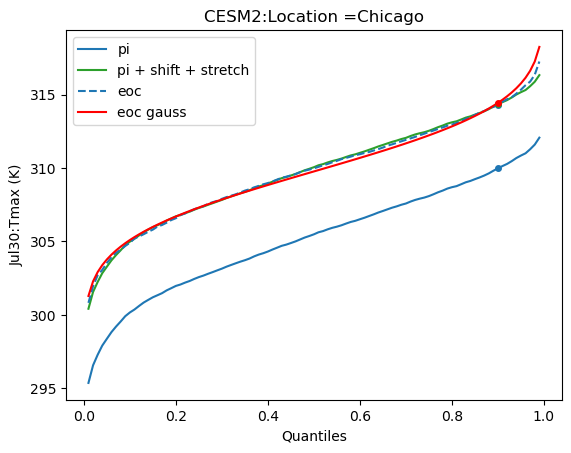

CPU times: user 1.23 s, sys: 89.9 ms, total: 1.32 s
Wall time: 7.91 s


In [33]:
%%time
plt.plot(quants,qdnw_loc1,color='tab:blue',label= 'pi')
# plt.plot(quants,qdmc,color='tab:orange',label= 'pi + shift')
plt.plot(quants,qdmsc_loc1,'tab:green',label='pi + shift + stretch')
plt.plot(quants,qdw_loc1,'--',color='tab:blue',label='eoc')
plt.plot(quants,qdwgauss_loc1,'red',label='eoc gauss')
# plt.plot(quants,qdnwgauss,'tab:red',label='pi gauss')
########### Markers ####################
plt.plot(0.9,qdw_loc1.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

plt.plot(0.9,qdnw_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2, ms=3, mew=2, color='tab:blue')

# plt.plot(0.9,qdmc.sel(quantile=0.9),marker='o',markerfacecolor='tab:orange',\
#          markeredgecolor='tab:orange', lw=2, ms=3, mew=2, color='tab:orange')

plt.plot(0.9,qdmsc_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2, ms=3, mew=2, color='tab:green')

plt.plot(0.9,qdwgauss_loc1.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2, ms=3, mew=2, color='red')

# plt.plot(0.9,qdnwgauss.sel(quantile=0.9),marker='o',markerfacecolor='tab:red',\
#         markeredgecolor='tab:red', lw=2, ms=3, mew=2, color='tab:red')
#############################
#plt.fill_between(quants,qdw_ci.sel(quantile=0.025),\
#qdw_ci.sel(quantile=0.975),color='b',alpha=0.2)
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn1)
plt.ylabel(date+':Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

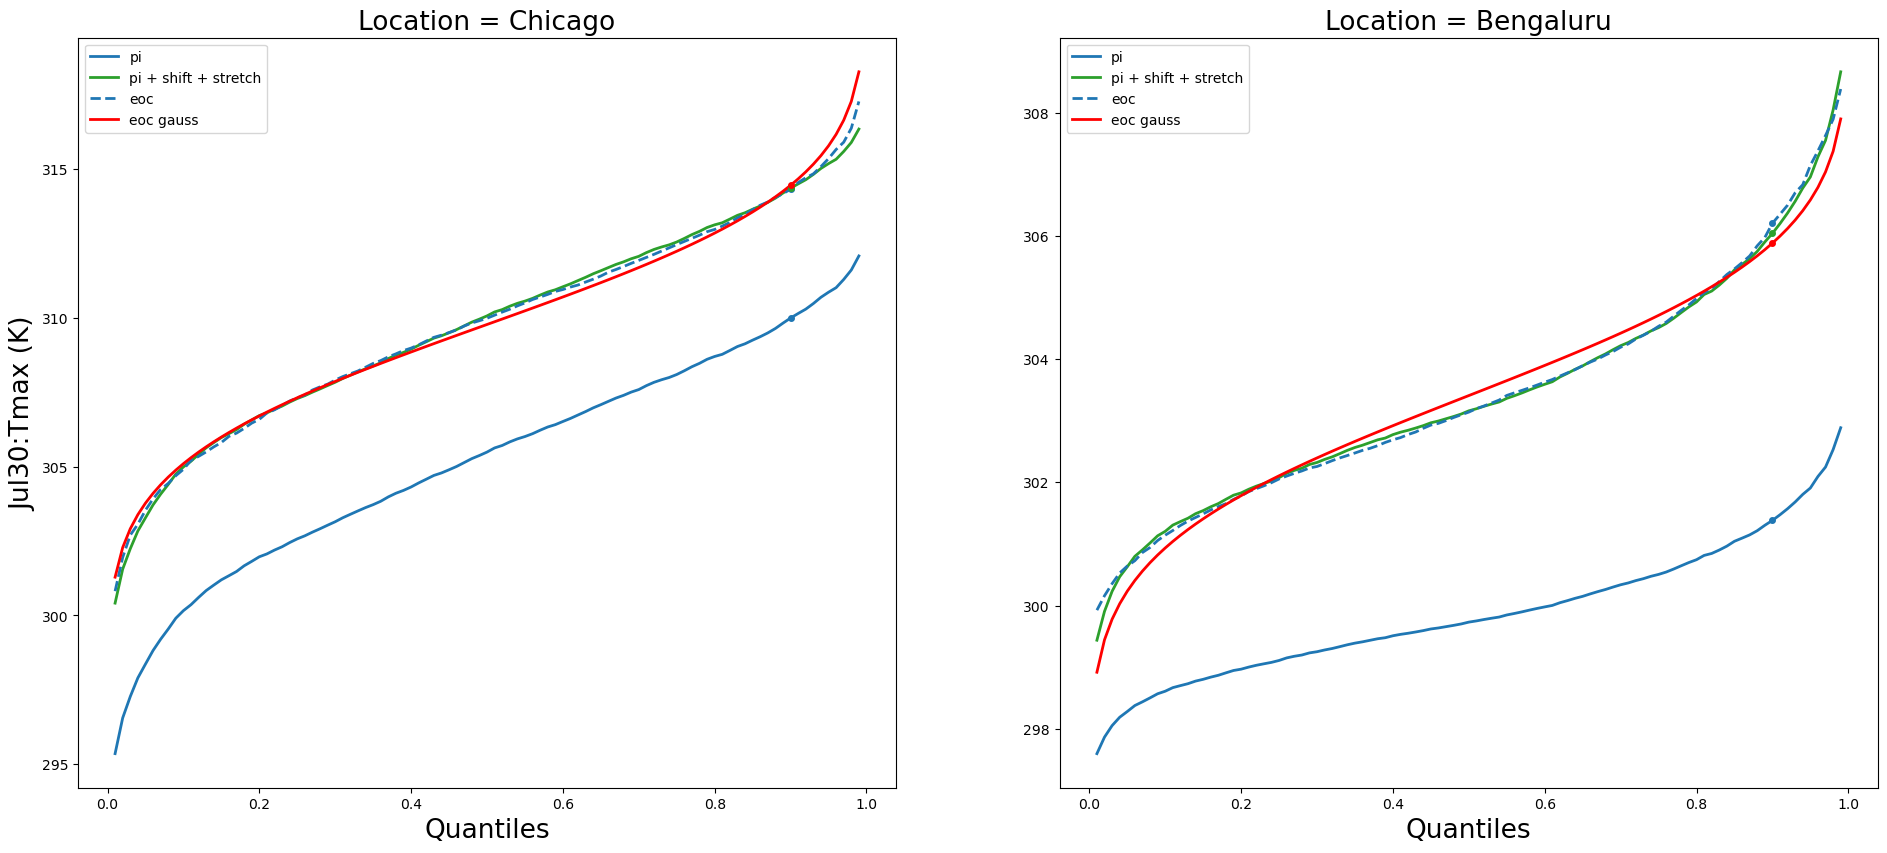

In [37]:
# Import required libraries
import matplotlib.pyplot as plt

# Setting up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10)) # 2 plots - side by side

#Plotting for loc1
axs[0].plot(quants,qdnw_loc1,color='tab:blue',label= 'pi',lw=2)
axs[0].plot(quants,qdmsc_loc1,color='tab:green',label='pi + shift + stretch',lw=2)
axs[0].plot(quants,qdw_loc1,'--',color='tab:blue',label='eoc',lw=2)
axs[0].plot(quants,qdwgauss_loc1,'red',label='eoc gauss',lw=2)
# Markers for loc1
axs[0].plot(0.9,qdw_loc1.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[0].plot(0.9,qdnw_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[0].plot(0.9,qdmsc_loc1.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2.3, ms=3, mew=2, color='tab:green')
axs[0].plot(0.9,qdwgauss_loc1.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2.3, ms=3, mew=2, color='red')
axs[0].legend(loc='upper left')
axs[0].set_title('Location = '+locn1,fontweight=500,fontsize=19)
axs[0].set_ylabel(date+':Tmax (K)',fontweight=500,fontsize=19)
axs[0].set_xlabel('Quantiles',fontweight=500,fontsize=19)

# Assuming you have similar data for loc2, here is how you would plot it
# Replace qdnw_loc2, qdmsc_loc2, etc. with your actual data variables for loc2

axs[1].plot(quants,qdnw_loc2,color='tab:blue',label= 'pi',lw=2)
axs[1].plot(quants,qdmsc_loc2,'tab:green',label='pi + shift + stretch',lw=2)
axs[1].plot(quants,qdw_loc2,'--',color='tab:blue',label='eoc',lw=2)
axs[1].plot(quants,qdwgauss_loc2,'red',label='eoc gauss',lw=2)
# Markers for loc2
axs[1].plot(0.9,qdw_loc2.sel(quantile=0.9),marker='o', markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[1].plot(0.9,qdnw_loc2.sel(quantile=0.9),marker='o',markerfacecolor='tab:blue',\
         markeredgecolor='tab:blue', lw=2.3, ms=3, mew=2, color='tab:blue')
axs[1].plot(0.9,qdmsc_loc2.sel(quantile=0.9),marker='o',markerfacecolor='tab:green',\
         markeredgecolor='tab:green', lw=2.3, ms=3, mew=2, color='tab:green')
axs[1].plot(0.9,qdwgauss_loc2.sel(quantile=0.9),marker='o',markerfacecolor='red',\
         markeredgecolor='red', lw=2.3, ms=3, mew=2, color='red')
axs[1].legend(loc='upper left')
axs[1].set_title('Location = '+locn2,fontweight=500,fontsize=19)
#axs[1].set_ylabel(date+':Tmax (K)')
axs[1].set_xlabel('Quantiles',fontweight=500,fontsize=19)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.05, right=0.95,
                    wspace=0.2, hspace=0.05)
# Finally, display the plots
# plt.tight_layout()
plt.show()

In [35]:
%%time
gauss_rmse1 = xs.rmse(qdwgauss_loc1,qdw_loc1)
gauss_rmse1.values

CPU times: user 1.16 s, sys: 108 ms, total: 1.26 s
Wall time: 10.6 s


array(0.25082997)

In [47]:
%%time
dmsc_rmse1 = xs.rmse(qdmsc_loc1,qdw_loc1)
dmsc_rmse1.values

CPU times: user 1.21 s, sys: 84.4 ms, total: 1.29 s
Wall time: 10.9 s


array(0.16762074)

In [39]:
%%time
dmsc_rmse2 = xs.rmse(qdmsc_loc2,qdw_loc2)
dmsc_rmse2.values

CPU times: user 1.23 s, sys: 81.6 ms, total: 1.31 s
Wall time: 11 s


array(0.0886498)

In [36]:
%%time
gauss_rmse2 = xs.rmse(qdwgauss_loc2,qdw_loc2)
gauss_rmse2.values

CPU times: user 1.32 s, sys: 99.8 ms, total: 1.42 s
Wall time: 12.1 s


array(0.28027985)

In [71]:
%%time
nwgauss_rmse = xs.rmse(qdnwgauss,qdnw)
nwgauss_rmse.values

CPU times: user 1.88 s, sys: 73.6 ms, total: 1.95 s
Wall time: 11 s


array(0.41171091)

In [73]:
%%time
dmc_rmse = xs.rmse(qdmc,qdw)
dmc_rmse.values

CPU times: user 89.8 ms, sys: 7.18 ms, total: 97 ms
Wall time: 203 ms


array(0.25711632)

In [74]:
%%time
dnw_rmse = xs.rmse(qdnw,qdw)
dnw_rmse.values

CPU times: user 61.8 ms, sys: 11.9 ms, total: 73.8 ms
Wall time: 158 ms


array(4.59618459)

In [75]:
gauss_rmse_check = (qdwgauss-qdw)**2
gauss_rmse_check = gauss_rmse_check.mean()
gauss_rmse_check = np.sqrt(gauss_rmse_check)
gauss_rmse_check.values

array(0.25082997)

In [76]:
# %%time
# qdw_arr   = qdw.to_numpy()
# qdmc_arr  = qdmc.to_numpy()
# qdmsc_arr = qdmsc.to_numpy()
# qdnw_arr  = qdnw.to_numpy()

NameError: name 'qdw_arr' is not defined

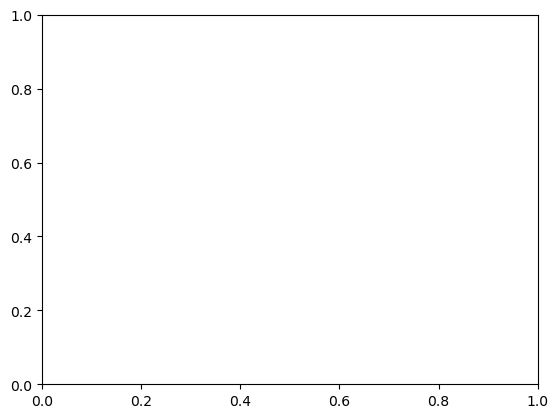

In [77]:
# Draw quantile-quantile plot
fig, ax = plt.subplots()
qqplot(qdw_arr, qdmc_arr, c='r', alpha=0.5, edgecolor='k',ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]  #Make the limits integers
lims = np.round(lims,0)
ax.axline((0, 0), slope=1)
plt.xlabel('Actual (K)')
plt.ylabel('pi + shift (K)')
plt.title('Q-Q plot, July 30 Tmax, CESM2: Bengaluru')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()
plt.close()

In [ ]:
%%time
quants  = np.arange(0,1.001,0.001)
plt.plot(quants,qdw_ci.sel(quantile=0.025)-qdw,color='r',label='CI_lb-actual')
plt.plot(quants,qdw_ci.sel(quantile=0.975)-qdw,color='g',label='CI_ub- actual')
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn+',bootstrap CIs')
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
%%time
quants  = np.arange(0,1.001,0.001)
plt.plot(quants,qdw-qdw_ci.sel(quantile=0.025),color='r',label='actual-CI_lb')
plt.plot(quants,qdw_ci.sel(quantile=0.975)-qdw,color='g',label='CI_ub- actual')
plt.legend(loc='upper left')
plt.title('CESM2:Location ='+locn+',bootstrap CIs')
plt.ylabel(date+'Tmax (K)')
plt.xlabel('Quantiles')
plt.show()

In [ ]:
qdw_ci.sel(quantile=0.025).values

In [ ]:
qdw_ci.sel(quantile=0.975).values

In [ ]:
qdw.values

In [ ]:
%%time
lb = (qdw_ci.sel(quantile=0.025)- qdw).to_numpy()
ub = (qdw_ci.sel(quantile=0.975)- qdw).to_numpy()

In [ ]:
np.set_printoptions(threshold=np.Inf)

In [ ]:
print(ub)

In [ ]:
print(lb)

In [ ]:
count = qdw.where((qdw_ci.sel(quantile=0.025)<=qdw)|\
                   (qdw <= qdw_ci.sel(quantile=0.975))).count()

In [ ]:
count.values

In [ ]:
qdw

In [ ]:
qdw.values

In [ ]:
qdw_ci.sel(quantile=0.025).values

In [ ]:
count2 = qdw.where((qdw_ci.sel(quantile=0.025)<=qdmsc)|\
                   (qdmsc <= qdw_ci.sel(quantile=0.975))).count()

In [ ]:
count2.values